In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from lime import lime_image
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
base_path = 'data/raw_data/'
IMG_SIZE = (224, 224)
df = pd.read_csv('Embeddings.csv')

In [10]:

def transform_image(image_path, img_size):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    return img_array

def load_image_data(df):
    image_data = []
    labels = []
    for i in range(len(df)):
        
        image = df['Image'].iloc[i]
        label = df['Class'].iloc[i]
        image_path = f"{base_path}{label}/{image}"
        normalized_img = transform_image(image_path, IMG_SIZE)
        flattened_img = normalized_img.flatten()
        image_data.append(flattened_img)
        labels.append(label)
    
    return np.array(image_data), np.array(labels)

In [11]:
X,y = load_image_data(df)

In [12]:
X

array([[0.46666667, 0.20784314, 0.10588235, ..., 0.53333336, 0.3529412 ,
        0.36078432],
       [0.14509805, 0.10196079, 0.07843138, ..., 0.2509804 , 0.15686275,
        0.10980392],
       [0.92941177, 0.28627452, 0.00784314, ..., 0.09411765, 0.00392157,
        0.02745098],
       ...,
       [0.90588236, 0.87058824, 0.94509804, ..., 0.9764706 , 0.9647059 ,
        0.99215686],
       [0.01176471, 0.01176471, 0.01176471, ..., 0.        , 0.        ,
        0.        ],
       [0.21176471, 0.2627451 , 0.29411766, ..., 0.3647059 , 0.43137255,
        0.4627451 ]], dtype=float32)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7918367346938775


In [25]:
base_path = 'data/raw_data/vase/'
img_path = base_path + 'n04522168_2044.JPEG'

img_path_bounding_box = "outputs/bounding_boxes_OPENAI/hotpot_vase/n04522168_2044_with_box.jpg"

In [26]:
img = transform_image(img_path, IMG_SIZE)
# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

def predict_fn(images):
    features = np.array([image.flatten() for image in images])
    return log_reg.predict_proba(features)

# Explain the prediction using LIME
explanation = explainer.explain_instance(
    img,
    predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

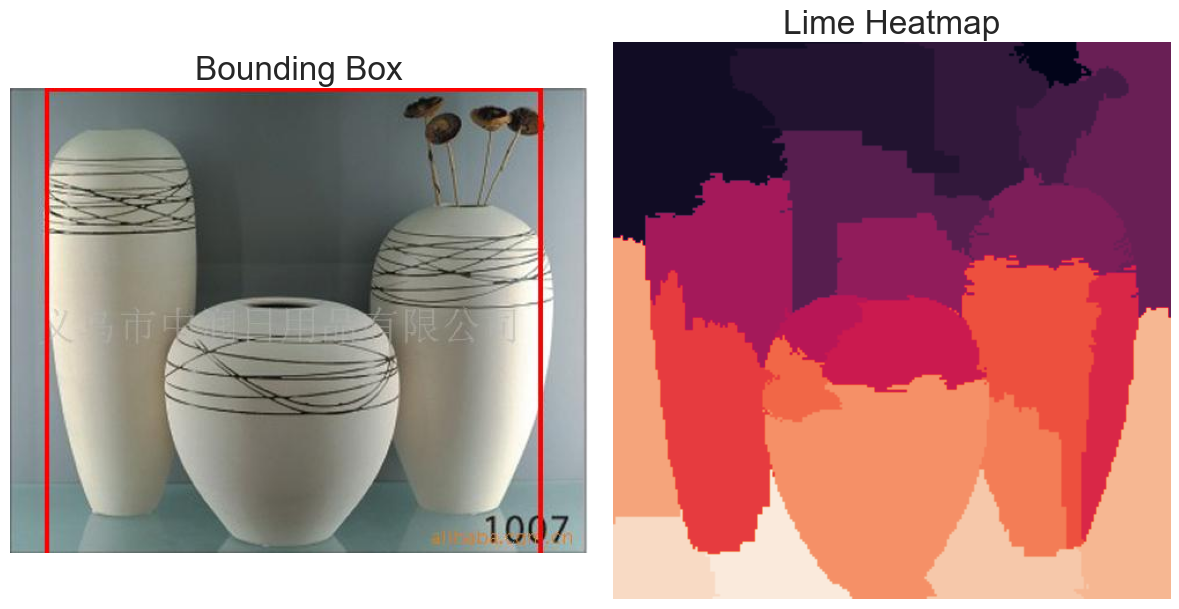

In [28]:
img_rgb = Image.open(img_path_bounding_box).convert("RGB")
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[1].imshow(explanation.segments)
ax[1].axis('off')
ax[1].set_title('Lime Heatmap', fontsize=24)

ax[0].imshow(img_rgb)
ax[0].axis('off')
ax[0].set_title('Bounding Box', fontsize=24)

plt.tight_layout()
plt.show()